In [1]:
!pip install -U nltk rouge_score

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=445b98a61465195649e358aece8ed8ef389bfaec368b9144f4c4aa805e14ffaf
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [2]:
from transformers import BertTokenizer, GPT2Tokenizer, EncoderDecoderModel
from torch.utils.data import Dataset, DataLoader
import json

#Model
from transformers import EncoderDecoderModel
import torch

# `Dataset`

In [3]:
class MedicalRecordDataset(Dataset):
    def __init__(self, data_file, encoder_tokenizer, decoder_tokenizer, max_input_len=512, max_output_len=512):
        with open(data_file, "r") as f:
            self.data = json.load(f)
            print(f"Loaded {len(self.data)} records from {data_file}")
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        text = record["text"]
        extraction = json.dumps(record["extraction"]) 
        
        # Tokenize input text for encoder
        encoder_inputs = self.encoder_tokenizer(
            text,
            max_length=self.max_input_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        # Tokenize target text for decoder
        decoder_inputs = self.decoder_tokenizer(
            extraction,
            max_length=self.max_output_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoder_inputs["input_ids"].squeeze(0),
            "attention_mask": encoder_inputs["attention_mask"].squeeze(0),
            "labels": decoder_inputs["input_ids"].squeeze(0)
        }

In [4]:
# Initialize tokenizers for encoder and decoder
encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
decoder_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token  # GPT2 requires this

# Prepare datasets
train_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/train.json", encoder_tokenizer, decoder_tokenizer)
test_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/test.json", encoder_tokenizer, decoder_tokenizer)
val_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/val.json", encoder_tokenizer, decoder_tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=2, pin_memory=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loaded 51338 records from /kaggle/input/information-extraction/train.json
Loaded 2009 records from /kaggle/input/information-extraction/test.json
Loaded 6000 records from /kaggle/input/information-extraction/val.json


In [6]:
train_dataset[0]

{'input_ids': tensor([  101,  5776,  2501,  2005,  8909, 13138, 19961,  2575,  1010,  6052,
          5890,  1013,  2321,  1013, 16798,  2475,  1012, 10886, 12087,  1024,
          3356, 16464,  8985,  1012,  7279, 28775, 21202,  2035, 24395,  3264,
          1012, 16250,  1024,  2572, 11636, 28775, 21202,  3156, 24798,  3807,
          3679,  2005,  2698,  2420,  1012,  2668,  5852,  1006, 13581,  1010,
         13675,  2361,  1007,  2864,  2006,  1996,  2168,  3058,  1010,  3463,
         14223,  1012,  6523,  7941,  3120,  1024,  2852,  1012, 15206,  1012,
          2279,  6098,  5115,  2005,  5890,  1013,  2756,  1013, 16798,  2475,
          1012,  5776,  3635,  1024,  5018, 20702,  1012,  5427,  1024, 29347,
          2102,  2532,  1010,  3343,  1001,  5925, 12521, 22022,  2629,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

# `Transformer Models`

In [5]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    "bert-base-uncased", 
    "gpt2" 
)

# Update decoder's config
model.config.decoder_start_token_id = decoder_tokenizer.bos_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# `Training`

In [6]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Track training and validation losses
train_losses, val_losses = [], []

def train_model(model, train_loader, val_loader, optimizer, epochs=20):
    global train_losses, val_losses
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_losses.append(train_loss / len(train_loader))
        print(f"Epoch {epoch + 1} Training Loss: {train_loss / len(train_loader):.4f}")
        
        # Validation phase
        val_loss = validate_model(model, val_loader)
        val_losses.append(val_loss)

        import gc
        gc.collect()
        torch.cuda.empty_cache()


def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            val_loss += outputs.loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

# Train the model
train_model(model, train_loader, test_loader, optimizer)

Epoch 1/20 - Training:   0%|          | 0/1250 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:629: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:649: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itse

Epoch 1 Training Loss: 0.1747


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Validation Loss: 0.0874


Epoch 2/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 2 Training Loss: 0.0680


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


Validation Loss: 0.0664


Epoch 3/20 - Training: 100%|██████████| 1250/1250 [14:01<00:00,  1.49it/s]


Epoch 3 Training Loss: 0.0463


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0453


Epoch 4/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 4 Training Loss: 0.0240


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


Validation Loss: 0.0265


Epoch 5/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 5 Training Loss: 0.0132


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0217


Epoch 6/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 6 Training Loss: 0.0095


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0197


Epoch 7/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 7 Training Loss: 0.0074


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0174


Epoch 8/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 8 Training Loss: 0.0061


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.62it/s]


Validation Loss: 0.0179


Epoch 9/20 - Training: 100%|██████████| 1250/1250 [13:59<00:00,  1.49it/s]


Epoch 9 Training Loss: 0.0053


Validating: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s]


Validation Loss: 0.0163


Epoch 10/20 - Training: 100%|██████████| 1250/1250 [13:59<00:00,  1.49it/s]


Epoch 10 Training Loss: 0.0043


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.62it/s]


Validation Loss: 0.0166


Epoch 11/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 11 Training Loss: 0.0038


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


Validation Loss: 0.0155


Epoch 12/20 - Training: 100%|██████████| 1250/1250 [14:01<00:00,  1.49it/s]


Epoch 12 Training Loss: 0.0034


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Validation Loss: 0.0164


Epoch 13/20 - Training: 100%|██████████| 1250/1250 [14:01<00:00,  1.49it/s]


Epoch 13 Training Loss: 0.0031


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Validation Loss: 0.0168


Epoch 14/20 - Training: 100%|██████████| 1250/1250 [14:01<00:00,  1.49it/s]


Epoch 14 Training Loss: 0.0029


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


Validation Loss: 0.0156


Epoch 15/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 15 Training Loss: 0.0023


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Validation Loss: 0.0172


Epoch 16/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 16 Training Loss: 0.0024


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0171


Epoch 17/20 - Training: 100%|██████████| 1250/1250 [13:59<00:00,  1.49it/s]


Epoch 17 Training Loss: 0.0023


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


Validation Loss: 0.0171


Epoch 18/20 - Training: 100%|██████████| 1250/1250 [13:59<00:00,  1.49it/s]


Epoch 18 Training Loss: 0.0019


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.62it/s]


Validation Loss: 0.0173


Epoch 19/20 - Training: 100%|██████████| 1250/1250 [13:59<00:00,  1.49it/s]


Epoch 19 Training Loss: 0.0017


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Validation Loss: 0.0174


Epoch 20/20 - Training: 100%|██████████| 1250/1250 [14:00<00:00,  1.49it/s]


Epoch 20 Training Loss: 0.0019


Validating: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


Validation Loss: 0.0178


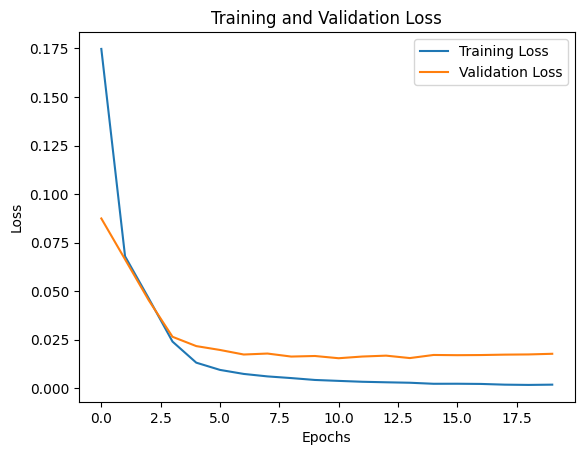

In [7]:
# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import json
import torch
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

def evaluate_model(model, data_loader, tokenizer):
    """
    Evaluate the model on the test set using Precision, Recall, F1-Score, BLEU Score, ROUGE, and METEOR.
    
    Args:
        model: Trained model to evaluate.
        data_loader: DataLoader for the test dataset.
        tokenizer: Tokenizer for decoding model outputs.
    
    Returns:
        Average Precision, Recall, F1-Score, BLEU Score, ROUGE-1, ROUGE-2, ROUGE-L, and METEOR.
    """
    model.eval()
    all_precisions, all_recalls, all_f1s = [], [], []
    all_bleus, all_meteors = [], []
    all_rouge1, all_rouge2, all_rougeL = [], [], []
    
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    for batch in tqdm(data_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=512
            )
        
        # Decode outputs and labels
        predictions = [tokenizer.decode(pred, skip_special_tokens=True) for pred in outputs]
        ground_truths = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]
        
        for pred, gt in zip(predictions, ground_truths):
            try:
                # Convert JSON strings back to Python objects for comparison
                pred_json = json.loads(pred)
                gt_json = json.loads(gt)
                
                # Evaluate individual keys
                for key in gt_json:
                    if key in pred_json:
                        pred_values = pred_json[key]
                        gt_values = gt_json[key]
                        
                        if isinstance(gt_values, list): 
                            p, r, f1 = evaluate_list(gt_values, pred_values)
                        else: 
                            p, r, f1 = evaluate_scalar(gt_values, pred_values)
                        
                        all_precisions.append(p)
                        all_recalls.append(r)
                        all_f1s.append(f1)
                    else:  # Key is missing
                        all_precisions.append(0)
                        all_recalls.append(0)
                        all_f1s.append(0)
                
                # Calculate BLEU score
                reference = [gt.split()]
                candidate = pred.split()
                bleu_score = sentence_bleu(reference, candidate)
                all_bleus.append(bleu_score)
                
                # Calculate METEOR score
                meteor = meteor_score([gt], pred)
                all_meteors.append(meteor)
                
                # Calculate ROUGE scores
                rouge_scores = rouge_scorer_obj.score(gt, pred)
                all_rouge1.append(rouge_scores['rouge1'].fmeasure)
                all_rouge2.append(rouge_scores['rouge2'].fmeasure)
                all_rougeL.append(rouge_scores['rougeL'].fmeasure)
                
            except json.JSONDecodeError:
                # Handle cases where the model output isn't valid JSON
                all_precisions.append(0)
                all_recalls.append(0)
                all_f1s.append(0)
                all_bleus.append(0)
                all_meteors.append(0)
                all_rouge1.append(0)
                all_rouge2.append(0)
                all_rougeL.append(0)

    # Calculate average metrics
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)
    avg_bleu = np.mean(all_bleus)
    avg_meteor = np.mean(all_meteors)
    avg_rouge1 = np.mean(all_rouge1)
    avg_rouge2 = np.mean(all_rouge2)
    avg_rougeL = np.mean(all_rougeL)
    
    print(f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")
    print(f"BLEU Score: {avg_bleu:.4f}, METEOR: {avg_meteor:.4f}")
    print(f"ROUGE-1: {avg_rouge1:.4f}, ROUGE-2: {avg_rouge2:.4f}, ROUGE-L: {avg_rougeL:.4f}")
    
    return avg_precision, avg_recall, avg_f1, avg_bleu, avg_meteor, avg_rouge1, avg_rouge2, avg_rougeL

def evaluate_scalar(gt_value, pred_value):
    """Evaluate precision, recall, and F1 for scalar values."""
    if gt_value == pred_value:
        return 1, 1, 1
    else:
        return 0, 0, 0

def evaluate_list(gt_list, pred_list):
    """Evaluate precision, recall, and F1 for lists of dictionaries."""
    # Convert lists of dicts to sets for comparison
    gt_set = {tuple(sorted(d.items())) for d in gt_list}
    pred_set = {tuple(sorted(d.items())) for d in pred_list}
    
    tp = len(gt_set & pred_set)  # True positives
    fp = len(pred_set - gt_set)  # False positives
    fn = len(gt_set - pred_set)  # False negatives
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0
    
    return precision, recall, f1

# Run evaluation
avg_precision, avg_recall, avg_f1, avg_bleu, avg_meteor, avg_rouge1, avg_rouge2, avg_rougeL = evaluate_model(model, test_loader, decoder_tokenizer)

Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Evaluating: 100%|██████████| 500/500 [20:13<00:00,  2.43s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 500/500 [20:13<00:00,  2.43s/it]

Precision: 0.2832, Recall: 0.3135, F1-Score: 0.2975
BLEU Score: 0.3250, METEOR: 0.3150
ROUGE-1: 0.3620, ROUGE-2: 0.2920, ROUGE-L: 0.3100


In [9]:
def save_model(model, path="/kaggle/working/transformer.pt"):
    torch.save(model.state_dict(), path)

def load_model(path="/kaggle/working/transformer.pt"):
    model = EncoderDecoderModel.from_encoder_decoder_pretrained(
        "bert-base-uncased", "gpt2"
    )
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model

save_model(model)

loaded_model = load_model()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

# `Testing model`

In [10]:
def extract_information(model, text):
    model.eval()
    inputs = encoder_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"])
    extraction = decoder_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extraction
    
# Example usage
input_text = "The patient, identified as 456789, visited on 4/15/2021 complaining of fatigue.  Known allergy to shellfish. Prescribed Zyrtec 10mg daily.  Comprehensive blood panel performed same day showed normal results. Referral from Dr. Smith. Next appointment: 5/15/2021.  Patient weighs 160 pounds.  Patient uses a Humana plan, policy # 55555."
result = extract_information(loaded_model, input_text)
print(result)

'''
{'patient_id': 456789,
'date_of_visit': '2021-04-15',
'allergy_type': 'Shellfish',
'medication_dosage': [{'name': 'Zyrtec', 'dosage': '10mg daily'}],
'lab_test_date': '2021-04-15',
'test_results': [{'name': 'Comprehensive blood panel', 'result': 'normal'}],
'referring_physician': 'Dr. Smith',
'follow_up_date': '2021-05-15',
'patient_weight': '160 pounds',
'insurance_information': [{'provider': 'Humana', 'policy_number': '55555'}]}
'''

patientid 456789 date_ofvisit 2021-0415 allergytype Shellfish lab_testdate 2021-0415 referring_physician Dr. Smith follow_update 2021-0515 patient_weight 160 pound